0    NOVA-RELAX
1          NOVA
2          PMFS
3        HUNTER
Name: file_system, dtype: object


'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


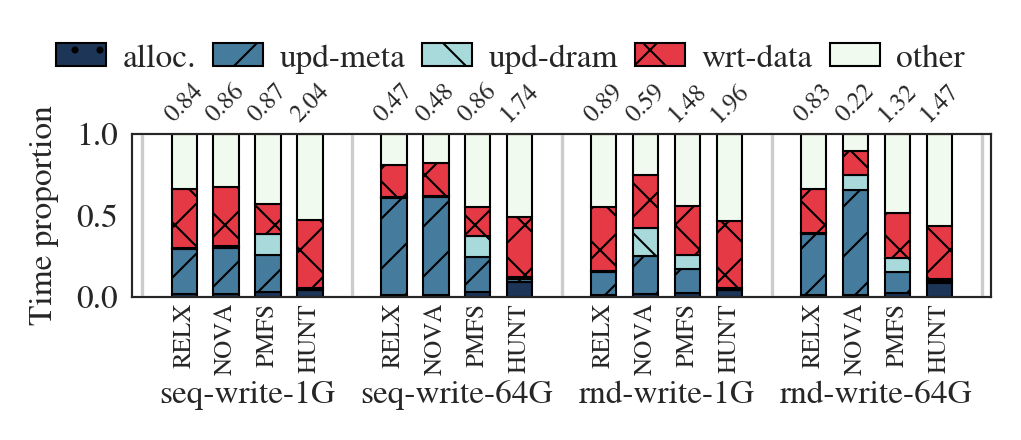

In [2]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import pandas as pd

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["axes.grid.which"] = "minor"
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["grid.linewidth"] = 0.8
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams['hatch.linewidth'] = 0.5
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

# Plotting Settings
fig,ax = plt.subplots()
fig.set_size_inches(cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(3.5))
fig.set_dpi(300)

bar_width = 0.2
patterns = ['..', '//', '\\\\', 'XX', '']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = ["#1d3557", "#457b9d", "#a8dadc", "#e63946", "#f1faee"] 
# colors.reverse()
times = ["allocate", "update-meta", "update-dram", "write-data", "other"]

x = [1, 2, 3, 4]
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
tot = len(fss) * bar_width

# normalize to 1
for i in range(0, 16):
    for time in times:
        df.loc[i, time] = df.iloc[i][time] / df.iloc[i]["total"]
    
global_points = []
print(fss)
for idx, fs in enumerate(fss):
    points = []
    for pivot in x:
        point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
        bottom = 0
        for i, time in enumerate(times):
            height = df[(df['file_system'] == fs)][time].iloc[pivot - 1] 
            # / 1000
            # y = df[df['file_system'] == fs][time].tolist()
            # plt.bar(points[i], y, bar_width, color=colors[i], label=time, hatch=patterns[i])
            plt.bar(point, height=height, width=bar_width * 0.6, hatch=patterns[i], edgecolor='black', color=colors[i], bottom=bottom, linewidth=0.5)
            bottom += height
        _fs = fs
        if fs == "NOVA-RELAX":
            _fs = "RELX"
        elif fs == "HUNTER":
            _fs = "HUNT"
        bw = round(df[df['file_system'] == fs]["bandwidth(MiB/s)"].iloc[pivot - 1] / 1024, 2)
        global_points.append((point, bw, _fs))

        # if pivot == 1:
        #     _fs = fs
        #     if fs == "NOVA-RELAX":
        #         _fs = "RELX."
        #     elif fs == "HUNTER":
        #         _fs = "HUNT."
        #     plt.text(point, bottom + 0.25, str(round(df[df['file_system'] == fs]["bandwidth(MiB/s)"].iloc[pivot - 1] / 1024, 2)) + "\n(" + _fs + ")", ha='center', va='center', rotation=90, fontsize=5)
        # else:
        #     plt.text(point, bottom + 0.25, round(df[df['file_system'] == fs]["bandwidth(MiB/s)"].iloc[pivot - 1]/ 1024, 2), ha='center', va='center', rotation=90, fontsize=7)
        
        # if pivot - 1 == idx:
        #     if fs == "NOVA-RELAX":
        #         plt.annotate(fs, xy=(point, bottom), xytext=(point + 0.2, bottom + 0.3 ), arrowprops=dict(arrowstyle="->", color='black', lw=0.5), ha='center', va='bottom', fontsize=6, bbox=dict(boxstyle='square,pad=-0.3',fc='none', ec='none'))
        #     else:
        #         plt.annotate(fs, xy=(point, bottom), xytext=(point, bottom + 0.3), arrowprops=dict(arrowstyle="->", color='black', lw=0.5), ha='center', va='bottom', fontsize=6, bbox=dict(boxstyle='square,pad=-0.3',fc='none', ec='none'))
            
# Draw title
plt.xticks(x, labels=["seq-write-1G", "seq-write-64G", "rnd-write-1G","rnd-write-64G"], fontsize=8)
plt.yticks([0, 0.5, 1.0], fontsize=8)
plt.ylim((0,1))
plt.ylabel('Time proportion', fontsize=8)

# plt.xlabel("File Size (GiB)", fontsize=8) 

fig.legend(pd.Series(times).map({
    "allocate": "alloc.",
    "update-meta": "upd-meta",
    "update-dram": "upd-dram",
    "write-data": "wrt-data",
    "other": "other",
}), loc='center', bbox_to_anchor=(0.5, 0.96), ncol=5, fontsize=8, columnspacing=0.5, handletextpad=0.5, handlelength=1.5)


ax2 = ax.twiny()
ax2.xaxis.set_minor_locator(AutoMinorLocator(1))
ax2.set_xlim(ax.get_xlim())
global_points.sort(key=lambda x: x[0])
ax2.set_xticks([x[0] for x in global_points])
ax2.set_xticklabels([x[1] for x in global_points], fontsize=6, rotation=45, ha='center', va='bottom', y=0.95)

# ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.set_xticks([x[0] for x in global_points],minor=True)
ax.set_xticklabels([x[2] for x in global_points], minor=True, fontsize=6, rotation=90, ha='center', va='top', y=0.05)
ax.tick_params(axis='x', which='major', pad=(20))
plt.tight_layout()

plt.savefig("./FIG-OverheadsBreakdown.pdf", bbox_inches='tight', pad_inches=0)
